In [1]:

import pandas as pd

In [2]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K


# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000]
test_data = data[20000:]

# Normalisation des données
scaler = StandardScaler()
train_data_x = scaler.fit_transform(train_data.drop(['anomaly', 'changepoint'], axis=1))
test_data_x = scaler.transform(test_data.drop(['anomaly', 'changepoint'], axis=1))
train_data_y = train_data[['anomaly']].values
test_data_y = test_data[['anomaly']].values


2024-10-21 23:26:02.951822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 23:26:03.213671: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 23:26:03.215116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 23:26:04.994263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


78/78 [==============================] - 0s 3ms/step


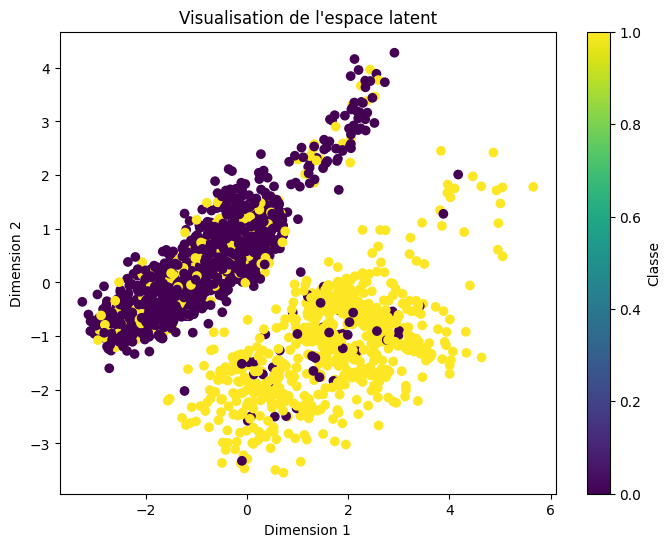

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import load_model


# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
encoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model4.h5'
encoder = load_model(encoder_path)

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Tracer les points de l'espace latent
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=test_data_y[:, 0], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent')
plt.colorbar(scatter, label='Classe')
plt.show()


78/78 [==============================] - 0s 2ms/step


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


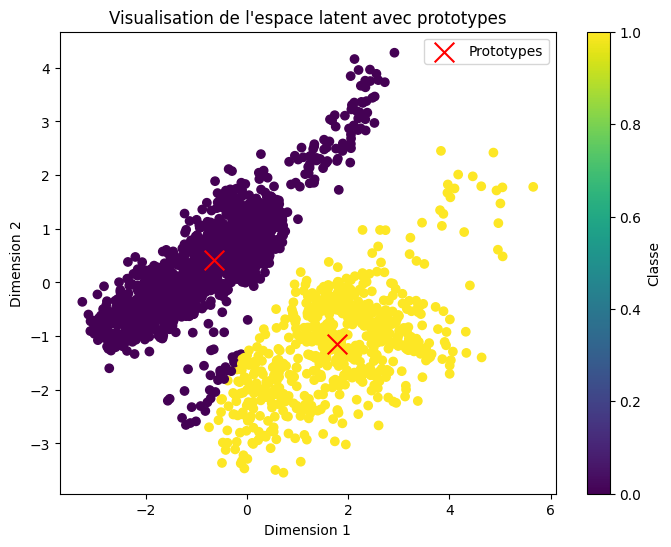

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent_2d)
prototypes = kmeans.cluster_centers_

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes[:, 0], prototypes[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [6]:
from tensorflow.keras.losses import mse

vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5', compile=False)


reconstructions = vae.predict(test_data_x, verbose=0)
reconstruction_error = mse(reconstructions, test_data_x)
print(reconstruction_error)

tf.Tensor([0.17590569 0.15765496 0.07137722 ... 0.0647147  0.10722334 0.0339262 ], shape=(2472,), dtype=float32)


In [7]:
y = test_data['anomaly']
y = y.astype(bool)

In [8]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.175906,True
1,0.157655,True
2,0.071377,True
3,0.311361,True
4,0.122072,True


In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0091	Accuracy: 0.395		Precision: 0.697	Recall Score: 0.500
Threshold: 0.0303	Accuracy: 0.429		Precision: 0.581	Recall Score: 0.521
Threshold: 0.0410	Accuracy: 0.474		Precision: 0.610	Recall Score: 0.553
Threshold: 0.0489	Accuracy: 0.512		Precision: 0.618	Recall Score: 0.579
Threshold: 0.0567	Accuracy: 0.559		Precision: 0.639	Recall Score: 0.613
Threshold: 0.0649	Accuracy: 0.598		Precision: 0.650	Recall Score: 0.640
Threshold: 0.0729	Accuracy: 0.638		Precision: 0.666	Recall Score: 0.667
Threshold: 0.0804	Accuracy: 0.662		Precision: 0.670	Recall Score: 0.677
Threshold: 0.0918	Accuracy: 0.688		Precision: 0.682	Recall Score: 0.690
Threshold: 0.1045	Accuracy: 0.714		Precision: 0.700	Recall Score: 0.701
Threshold: 0.1194	Accuracy: 0.725		Precision: 0.714	Recall Score: 0.699
Threshold: 0.1376	Accuracy: 0.714		Precision: 0.711	Recall Score: 0.673
Threshold: 0.1609	Accuracy: 0.703		Precision: 0.718	Recall Score: 0.646
Threshold: 0.1931	Accuracy: 0.681		Precision: 0.724	Recall Score

In [11]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.104483


In [12]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.175906,True,True
1,0.157655,True,True
2,0.071377,True,False
3,0.311361,True,True
4,0.122072,True,True
...,...,...,...
2467,0.061845,False,False
2468,0.041467,False,False
2469,0.064715,False,False
2470,0.107223,False,True


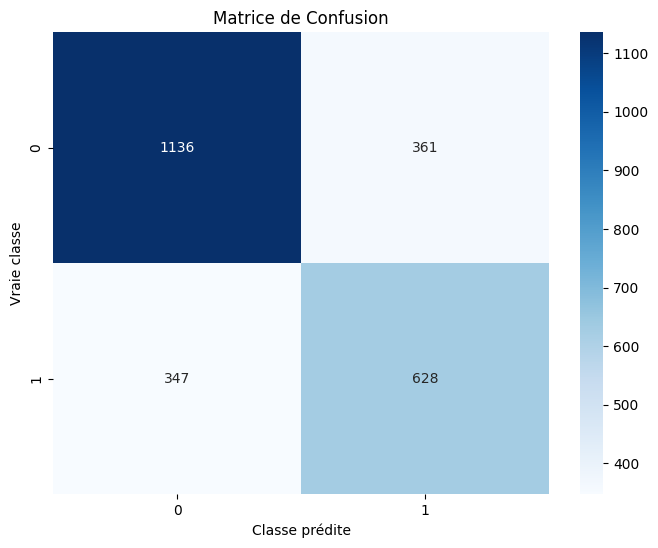

F1-score : 0.6395
Taux de faux positifs(fausses alarmes) : 0.24
Taux de faux négatifs(manque d'alarmes) : 0.36


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [14]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Trouver le seuil "top-k"
n_true_anomalies = recons_df['y_true'].sum()
recons_df = recons_df.sort_values('error', ascending=False)
recons_df['predicted_anomaly'] = 0
recons_df.loc[:n_true_anomalies-1, 'predicted_anomaly'] = 1

top_k_threshold = recons_df.iloc[n_true_anomalies-1]['error']

print(f"Top-k threshold: {top_k_threshold:.4f}")
print(f"Precision: {precision_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")
print(f"Recall: {recall_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")
print(f"F1-score: {f1_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")

Top-k threshold: 0.1057
Precision: 0.6282
Recall: 0.6533
F1-score: 0.6405


In [15]:
recons_df['predicted_anomaly'] = recons_df['error'] > top_k_threshold
recons_df

,error,y_true,y_pred,predicted_anomaly
871,1.450787,True,True,True
987,1.296402,True,True,True
1195,1.235917,True,True,True
1240,1.217620,False,True,True
2376,1.121081,False,True,True
...,...,...,...,...
1750,0.010904,False,False,False
1539,0.010208,False,False,False
1075,0.009331,True,False,False
1094,0.009223,True,False,False


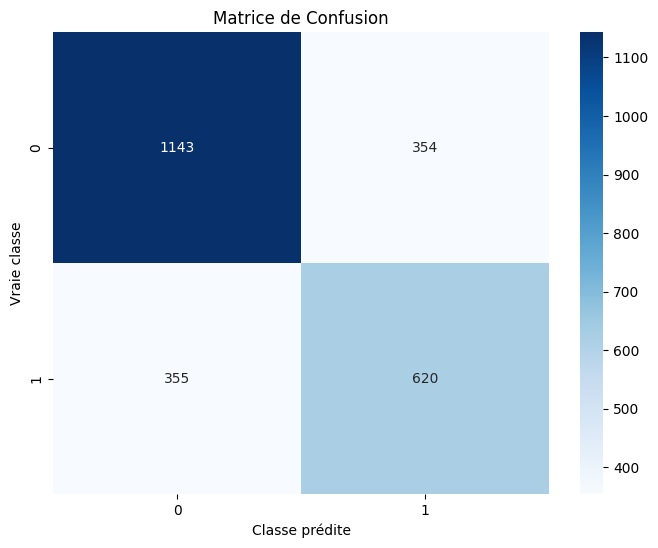

F1-score : 0.6362
Taux de faux positifs(fausses alarmes) : 0.24
Taux de faux négatifs(manque d'alarmes) : 0.36


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [17]:
import pandas as pd
from sklearn.metrics import f1_score

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Trouver le seuil qui maximise le F1-score
best_f1 = 0
best_threshold = None

for threshold in sorted(recons_df['error'].unique()):
    recons_df['predicted_anomaly'] = (recons_df['error'] > threshold).astype(int)
    f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1-score: {best_f1:.4f}")
print(f"Best threshold: {best_threshold:.4f}")

Best F1-score: 0.6425
Best threshold: 0.0871


In [18]:
recons_df['y_pred'] = recons_df['error'] > best_threshold
recons_df

,error,y_true,y_pred,predicted_anomaly
871,1.450787,True,True,0
987,1.296402,True,True,0
1195,1.235917,True,True,0
1240,1.217620,False,True,0
2376,1.121081,False,True,0
...,...,...,...,...
1750,0.010904,False,False,0
1539,0.010208,False,False,0
1075,0.009331,True,False,0
1094,0.009223,True,False,0


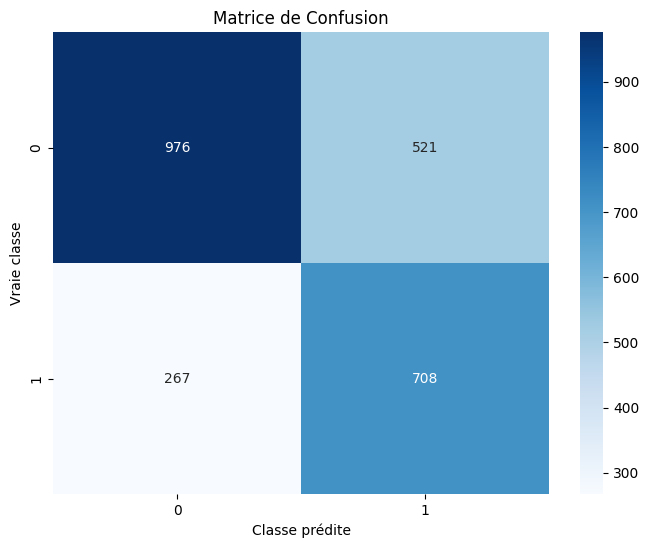

F1-score : 0.6425
Taux de faux positifs(fausses alarmes) : 0.35
Taux de faux négatifs(manque d'alarmes) : 0.27


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

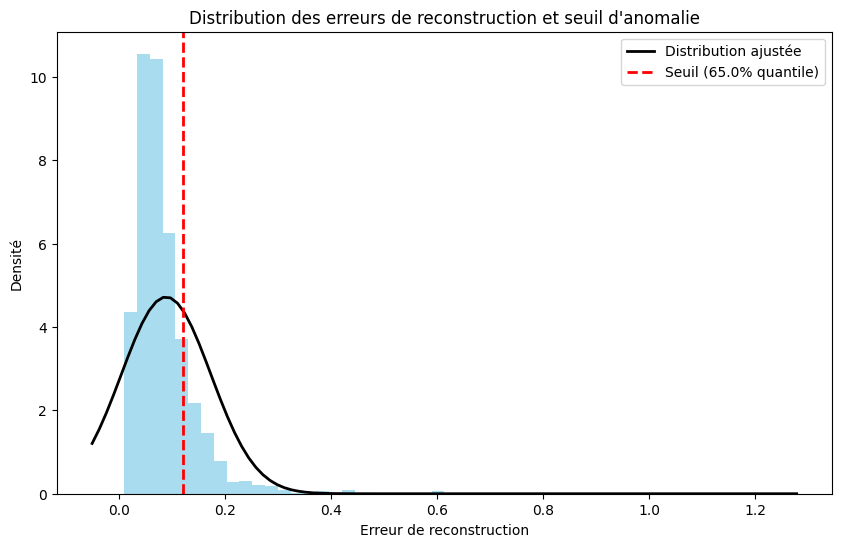

Seuil basé sur le 65.0% quantile: 0.1208

Matrice de confusion:
Predicted     0    1
Actual              
False      1238  259
True        422  553

Précision: 0.6810
Rappel: 0.5672
F1-score: 0.6189


In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Séparer les erreurs de reconstruction des instances normales
normal_errors = recons_df[recons_df['y_true'] == 0]['error']

# Ajuster une distribution gaussienne aux erreurs de reconstruction normales
mu, std = stats.norm.fit(normal_errors)

# Définir un quantile élevé (par exemple, 99%)
quantile = 0.65

# Calculer le seuil basé sur le quantile choisi
threshold = stats.norm.ppf(quantile, mu, std)

# Visualiser la distribution et le seuil
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, density=True, alpha=0.7, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title("Distribution des erreurs de reconstruction et seuil d'anomalie")
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Densité")
plt.legend(['Distribution ajustée', f'Seuil ({quantile*100}% quantile)'])
plt.show()

# Appliquer le seuil pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > threshold).astype(int)

# Afficher les résultats
print(f"Seuil basé sur le {quantile*100}% quantile: {threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [21]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred,predicted_anomaly
871,1.450787,True,True,1
987,1.296402,True,True,1
1195,1.235917,True,True,1
1240,1.217620,False,True,1
2376,1.121081,False,True,1
...,...,...,...,...
1750,0.010904,False,False,0
1539,0.010208,False,False,0
1075,0.009331,True,False,0
1094,0.009223,True,False,0


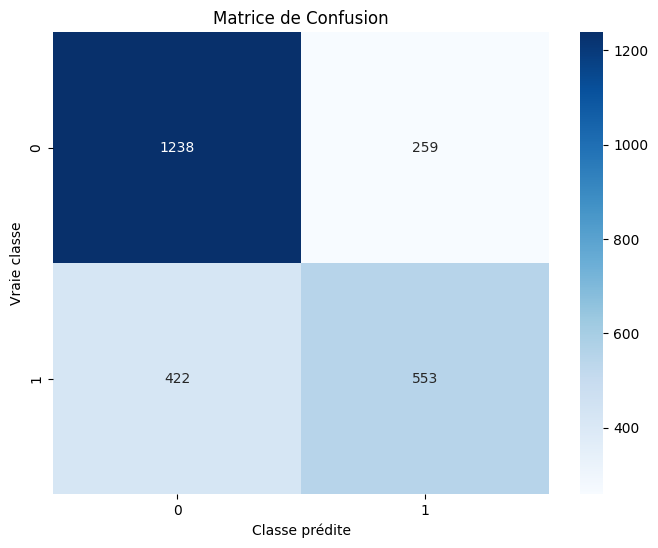

F1-score : 0.6189
Taux de faux positifs(fausses alarmes) : 0.17
Taux de faux négatifs(manque d'alarmes) : 0.43


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

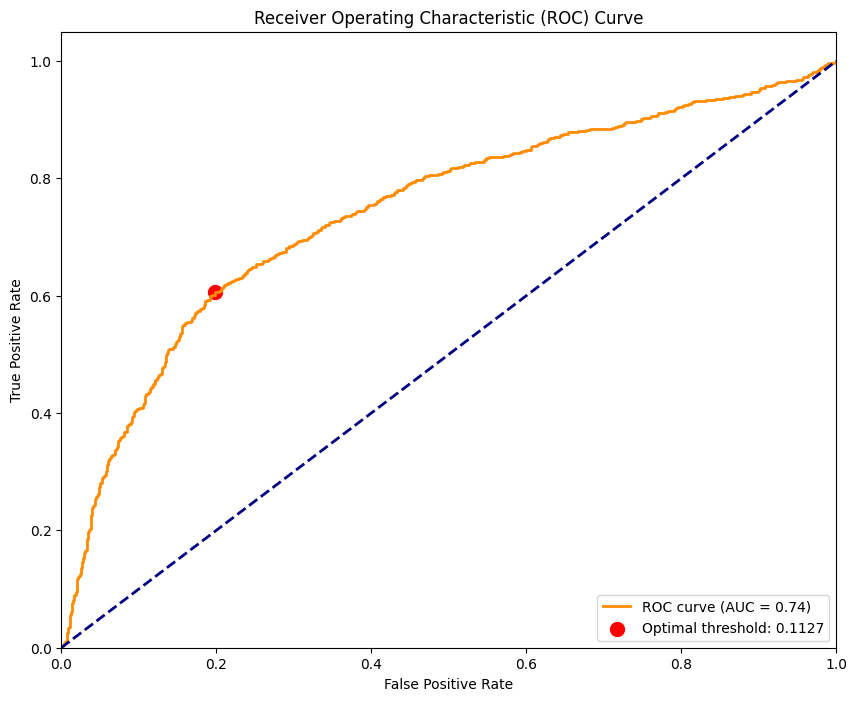

Seuil optimal: 0.1127

Matrice de confusion:
Predicted     0    1
Actual              
False      1200  297
True        385  590

Précision: 0.6652
Rappel: 0.6051
F1-score: 0.6337


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme vous l'avez indiqué
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(recons_df['y_true'], recons_df['error'])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Trouver le point optimal sur la courbe ROC (point le plus proche du coin supérieur gauche)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tracer la courbe ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Optimal threshold: {optimal_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Appliquer le seuil optimal pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold).astype(int)

# Afficher les résultats
print(f"Seuil optimal: {optimal_threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [24]:
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold)
recons_df

,error,y_true,y_pred,predicted_anomaly
871,1.450787,True,True,True
987,1.296402,True,True,True
1195,1.235917,True,True,True
1240,1.217620,False,True,True
2376,1.121081,False,True,True
...,...,...,...,...
1750,0.010904,False,False,False
1539,0.010208,False,False,False
1075,0.009331,True,False,False
1094,0.009223,True,False,False


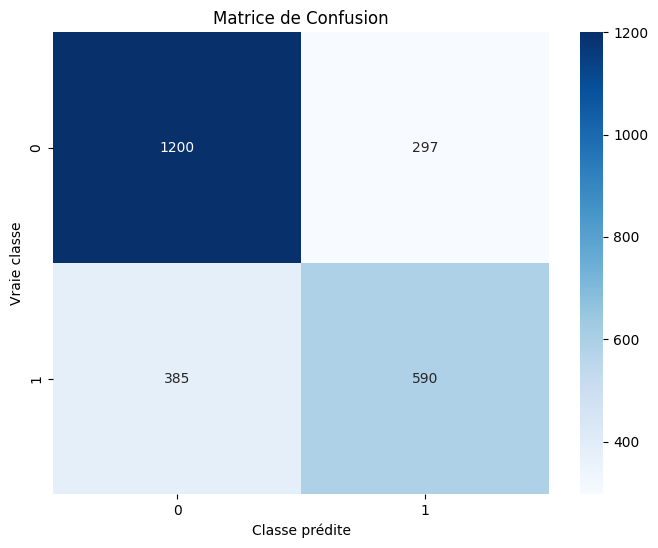

F1-score : 0.6337
Taux de faux positifs(fausses alarmes) : 0.20
Taux de faux négatifs(manque d'alarmes) : 0.39


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")